In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


5
0
4
1
9
2
1
3
1


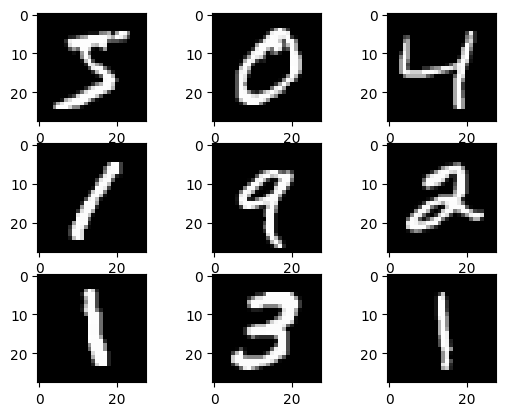

In [3]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    print(train_labels[i])
# show the figure
plt.show()

In [4]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Angel Test Model

In [5]:
angel_model = models.Sequential()
angel_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
angel_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
angel_model.add(layers.AveragePooling2D((2, 2)))
angel_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
angel_model.add(layers.Flatten())
angel_model.add(layers.Dense(64, activation='relu'))
angel_model.add(layers.Dense(10))

In [6]:
angel_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 64)                409664    
                                                        

In [7]:
angel_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

angel_history = angel_model.fit(train_images, train_labels, batch_size=32, epochs=15,
                    callbacks=callback, validation_data=(test_images, test_labels))

Epoch 1/15
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1263 - accuracy: 0.9620 - val_loss: 0.0414 - val_accuracy: 0.9859
Epoch 2/15
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0398 - accuracy: 0.9873 - val_loss: 0.0413 - val_accuracy: 0.9866
Epoch 3/15
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.0318 - val_accuracy: 0.9892
Epoch 4/15
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0358 - val_accuracy: 0.9885
Epoch 5/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0287 - val_accuracy: 0.9907
Epoch 6/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.0314 - val_accuracy: 0.9918
Epoch 7/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0326 -

#### Evaluate Angel's Model

313/313 - 2s - loss: 0.0428 - accuracy: 0.9891 - 2s/epoch - 6ms/step


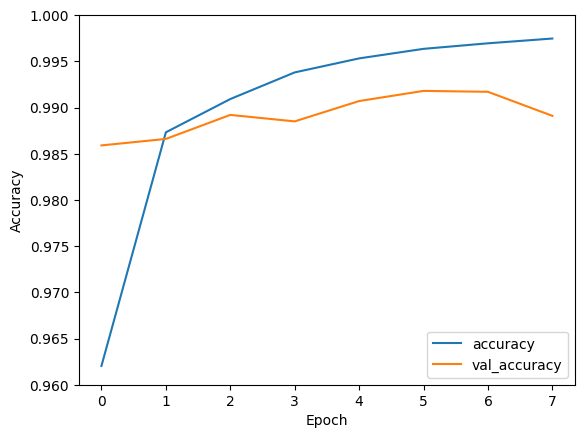

In [8]:
plt.plot(angel_history.history['accuracy'], label='accuracy')
plt.plot(angel_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1])
plt.legend(loc='lower right')

test_loss, test_acc = angel_model.evaluate(test_images,  test_labels, verbose=2)

In [9]:
# Save model
angel_model.save('angel_model')

INFO:tensorflow:Assets written to: angel_model\assets


### John Test Model

In [10]:
john_model = models.Sequential()
john_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
john_model.add(layers.AveragePooling2D((2, 2)))
john_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
john_model.add(layers.AveragePooling2D((2, 2)))
john_model.add(layers.Flatten())
john_model.add(layers.Dense(64, activation='relu'))
john_model.add(layers.Dense(10))

In [11]:
john_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 13, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 average_pooling2d_2 (Averag  (None, 5, 5, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [12]:
john_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

john_history = john_model.fit(train_images, train_labels, batch_size=32, epochs=15,
                    callbacks=callback, validation_data=(test_images, test_labels))

Epoch 1/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1743 - accuracy: 0.9476 - val_loss: 0.0582 - val_accuracy: 0.9809
Epoch 2/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0592 - accuracy: 0.9823 - val_loss: 0.0421 - val_accuracy: 0.9877
Epoch 3/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0416 - accuracy: 0.9869 - val_loss: 0.0365 - val_accuracy: 0.9873
Epoch 4/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0324 - val_accuracy: 0.9897
Epoch 5/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0277 - val_accuracy: 0.9920
Epoch 6/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0393 - val_accuracy: 0.9883
Epoch 7/15
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0313 - val_ac

#### Evaluate John's Model

313/313 - 1s - loss: 0.0367 - accuracy: 0.9898 - 847ms/epoch - 3ms/step


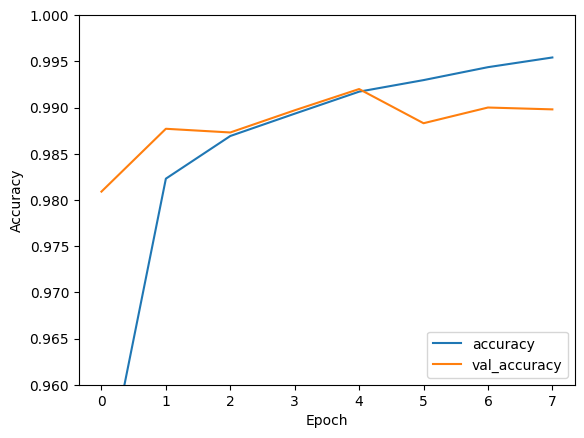

In [13]:
plt.plot(john_history.history['accuracy'], label='accuracy')
plt.plot(john_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1])
plt.legend(loc='lower right')

test_loss, test_acc = john_model.evaluate(test_images,  test_labels, verbose=2)

In [14]:
john_model.save('john_model')

INFO:tensorflow:Assets written to: john_model\assets


### Justin Test Model

In [15]:
justin_model = models.Sequential()
justin_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
justin_model.add(layers.Dropout(0.2))
justin_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
justin_model.add(layers.AveragePooling2D((2, 2)))
justin_model.add(layers.Flatten())
justin_model.add(layers.Dense(64, activation='relu'))
justin_model.add(layers.Dense(10))

In [16]:
justin_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 average_pooling2d_3 (Averag  (None, 12, 12, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                589888    
                                                      

In [17]:
justin_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

justin_history = justin_model.fit(train_images, train_labels, batch_size=32, epochs=15,
                    callbacks=callback, validation_data=(test_images, test_labels))

Epoch 1/15
1875/1875 [==============================] - 56s 30ms/step - loss: 0.1333 - accuracy: 0.9592 - val_loss: 0.0495 - val_accuracy: 0.9830
Epoch 2/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0455 - accuracy: 0.9855 - val_loss: 0.0386 - val_accuracy: 0.9860
Epoch 3/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.0382 - val_accuracy: 0.9868
Epoch 4/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.0292 - val_accuracy: 0.9898
Epoch 5/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0353 - val_accuracy: 0.9891
Epoch 6/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0366 - val_accuracy: 0.9894
Epoch 7/15
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.0372 -

313/313 - 2s - loss: 0.0372 - accuracy: 0.9895 - 2s/epoch - 6ms/step


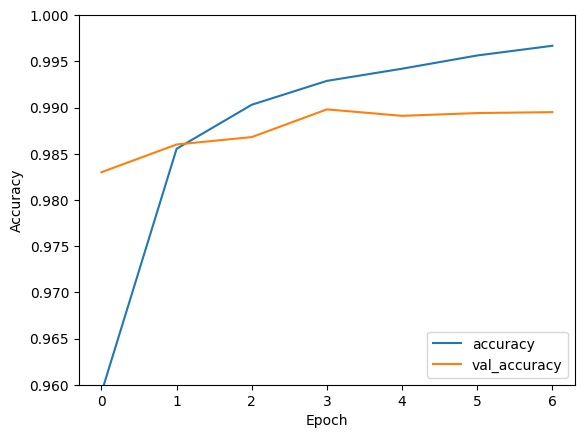

In [18]:
plt.plot(justin_history.history['accuracy'], label='accuracy')
plt.plot(justin_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1])
plt.legend(loc='lower right')

test_loss, test_acc = justin_model.evaluate(test_images,  test_labels, verbose=2)

In [19]:
justin_model.save('justin_model')

INFO:tensorflow:Assets written to: justin_model\assets
